In [45]:
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report


class DropOtherColumns(BaseEstimator, TransformerMixin):
    def __init__(self, prefix='Other'):
        self.prefix = prefix
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        other_columns = [col for col in X.columns if col.startswith(self.prefix)]
        return X.drop(columns=other_columns, errors='ignore')

regressor_paths = {
    'RandomForestRegressor': "regression/RandomForestRegressor.pkl",
    'GradientBoostingRegressor': "regression/GradientBoostingRegressor.pkl",
    'AdaBoostRegressor': "regression/AdaBoostRegressor.pkl",
    'DecisionTreeRegressor': "regression/DecisionTreeRegressor.pkl",
    'ElasticNetRegressor': "regression/ElasticNetRegressor.pkl",
    'KNNRegressor': "../models/regression/KNNRegressor.pkl"
    
}

classifier_paths = {
    'RandomForestClassifier': "classification/RandomForestClassifier.pkl",
    'AdaBoostClassifier': "classification/AdaBoostClassifier.pkl",
    'GaussianNB': "classification/GaussianNBClassifier.pkl",
    'KNNClassifier': "classification/KNNClassifier.pkl",
    'LogisticRegression': "classification/LogisticRegression.pkl",
    'SVCclassifier': "classification/SVCclassifier.pkl"
    
}

def load_model(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

regressors = {name: load_model(path) for name, path in regressor_paths.items()}
classifiers = {name: load_model(path) for name, path in classifier_paths.items()}


In [46]:

def get_regressor_predictions(regressor, X_train, X_test):
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    return y_train_pred, y_test_pred

def get_classifier_predictions(classifier, X_train, X_test):
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    return y_train_pred, y_test_pred


In [47]:

df = pd.read_csv('../dataset/preprocessed_dataset.csv')
df = df.drop('votes', axis=1)
df = df.drop('avg_vote', axis=1)
X_reg = df.drop('revenue_with_CPI', axis=1)
y_reg = df['revenue_with_CPI']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


df = pd.read_csv('../dataset/discretized_dataset.csv')

def multi_value_one_hot(df, column):
    s = df[column].str.get_dummies(sep=', ')
    return df.join(s.add_prefix(column + '_'))

df = multi_value_one_hot(df, 'genre')
df.drop(columns=['genre'], inplace=True)
df['month_published'] = df['month_published'].astype(str)

X_cla = df.drop('revenue_cluster', axis=1)
y_cla = df['revenue_cluster']

X_train_cla, X_test_cla, y_train_cla, y_test_cla = train_test_split(X_cla, y_cla, test_size=0.2, random_state=42, stratify=y_cla)

In [48]:
def one_away_accuracy(y_true, y_pred):
    class_order = [3, 1, 0, 2]
    correct = 0
    for yt, yp in zip(y_true, y_pred):
        idx_true = class_order.index(yt)
        idx_pred = class_order.index(yp)
        if abs(idx_true - idx_pred) <= 1:
            correct += 1
    return correct / len(y_true)

def evaluate_regressor(y_train, y_train_pred, y_test, y_test_pred):
    metrics = {}
    metrics['train_rmse'] = mean_squared_error(y_train, y_train_pred, squared=False)
    metrics['train_mae'] = mean_absolute_error(y_train, y_train_pred)
    metrics['train_r2'] = r2_score(y_train, y_train_pred)
    metrics['test_rmse'] = mean_squared_error(y_test, y_test_pred, squared=False)
    metrics['test_mae'] = mean_absolute_error(y_test, y_test_pred)
    metrics['test_r2'] = r2_score(y_test, y_test_pred)
    return metrics

def evaluate_classifier(y_train, y_train_pred, y_test, y_test_pred):
    metrics = {}
    metrics['train_accuracy'] = accuracy_score(y_train, y_train_pred)
    metrics['test_accuracy'] = accuracy_score(y_test, y_test_pred)
    metrics['train_one_away_accuracy'] = one_away_accuracy(y_train, y_train_pred)
    metrics['test_one_away_accuracy'] = one_away_accuracy(y_test, y_test_pred)
    metrics['classification_report_train'] = classification_report(y_train, y_train_pred)
    metrics['classification_report_test'] = classification_report(y_test, y_test_pred)
    return metrics


In [49]:

regressor_metrics = {}
for name, regressor in regressors.items():
    y_train_pred, y_test_pred = get_regressor_predictions(regressor, X_train_reg, X_test_reg)
    regressor_metrics[name] = evaluate_regressor(y_train_reg, y_train_pred, y_test_reg, y_test_pred)

print("Regressor Metrics:")
for name, metrics in regressor_metrics.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

classifier_metrics = {}
for name, classifier in classifiers.items():
    y_train_pred, y_test_pred = get_classifier_predictions(classifier, X_train_cla, X_test_cla)
    classifier_metrics[name] = evaluate_classifier(y_train_cla, y_train_pred, y_test_cla, y_test_pred)

print("\nClassifier Metrics:")
for name, metrics in classifier_metrics.items():
    print(f"\n{name}:")
    print("Train set:")
    print(metrics['classification_report_train'])
    print("Test set:")
    print(metrics['classification_report_test'])
    print(f"Train accuracy: {metrics['train_accuracy']}")
    print(f"Test accuracy: {metrics['test_accuracy']}")
    print(f"One away Train accuracy: {metrics['train_one_away_accuracy']}")
    print(f"One away Test accuracy: {metrics['test_one_away_accuracy']}")


Regressor Metrics:

RandomForestRegressor:
train_rmse: 163423686.50702277
train_mae: 58019523.746770635
train_r2: 0.6835693189713254
test_rmse: 207184974.83640644
test_mae: 82376330.61702259
test_r2: 0.4230637954316091

GradientBoostingRegressor:
train_rmse: 199650305.7017214
train_mae: 77359532.15199389
train_r2: 0.5277319790904333
test_rmse: 218256233.40746337
test_mae: 83342728.40080352
test_r2: 0.359757364960937

AdaBoostRegressor:
train_rmse: 214334578.56208
train_mae: 82018095.73655291
train_r2: 0.45570660713024935
test_rmse: 213376611.619415
test_mae: 85714908.53466384
test_r2: 0.38806554349211964

DecisionTreeRegressor:
train_rmse: 192282060.24231526
train_mae: 71758403.94561547
train_r2: 0.5619475502542429
test_rmse: 234266887.36524343
test_mae: 88005703.68190682
test_r2: 0.2623793036673354

ElasticNetRegressor:
train_rmse: 273842741.7020254
train_mae: 118242345.18430261
train_r2: 0.11151306013619999
test_rmse: 255072458.62690815
test_mae: 119316715.32961605
test_r2: 0.1255430

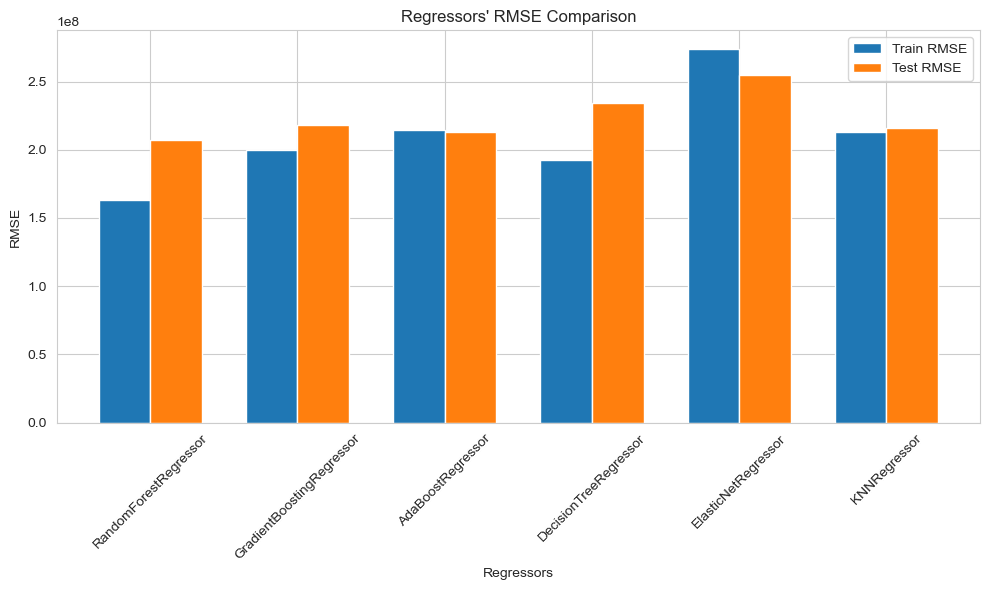

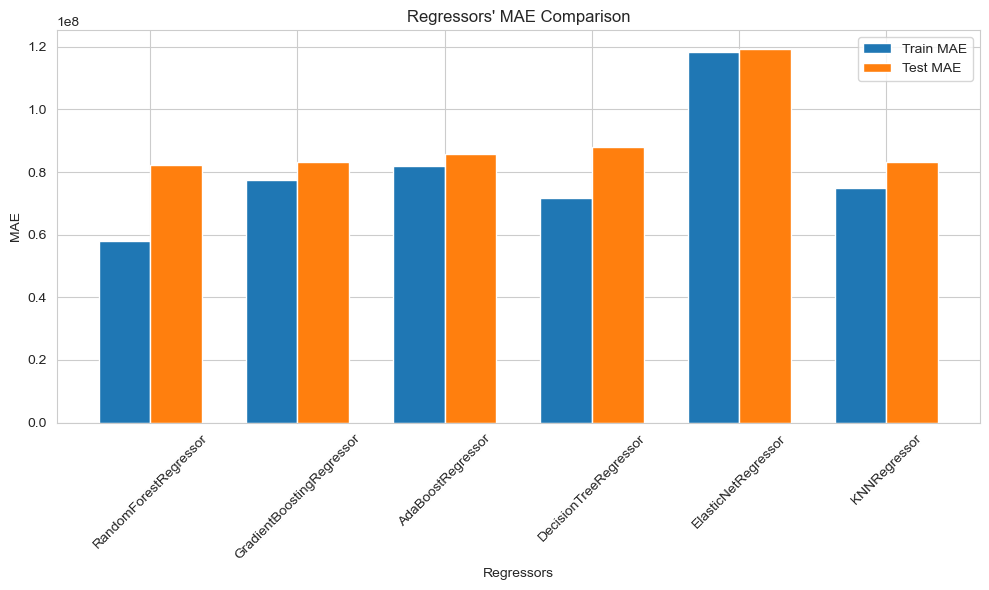

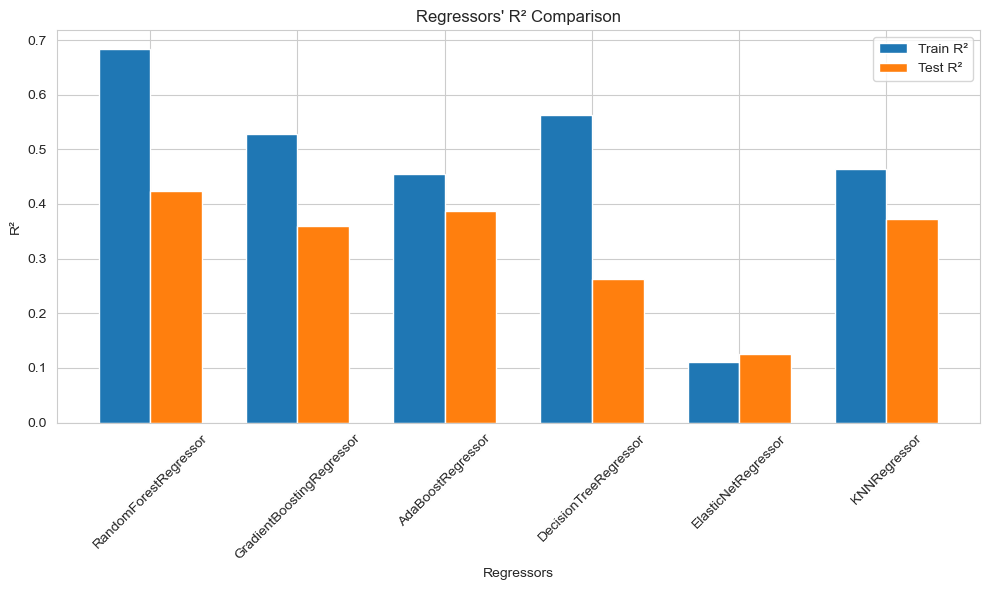

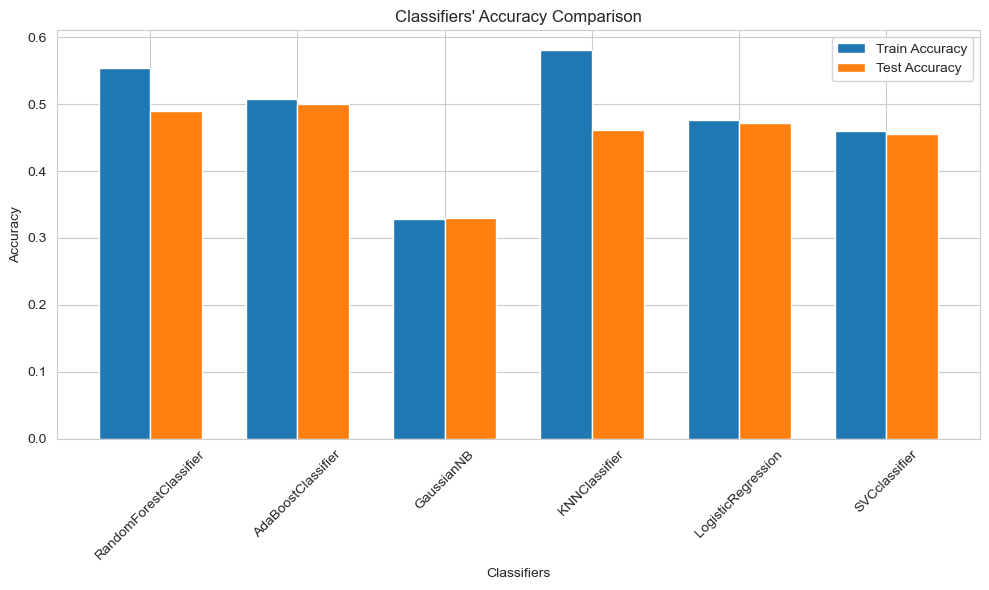

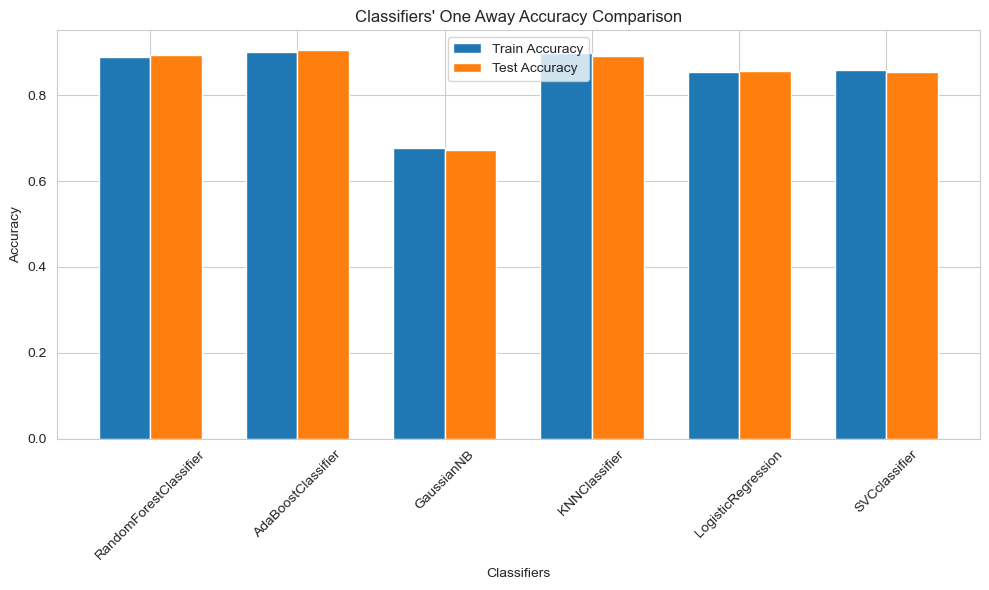

In [54]:
#regressors
regressor_names = list(regressor_metrics.keys())
train_rmse = [metrics['train_rmse'] for metrics in regressor_metrics.values()]
test_rmse = [metrics['test_rmse'] for metrics in regressor_metrics.values()]
train_mae = [metrics['train_mae'] for metrics in regressor_metrics.values()]
test_mae = [metrics['test_mae'] for metrics in regressor_metrics.values()]
train_r2 = [metrics['train_r2'] for metrics in regressor_metrics.values()]
test_r2 = [metrics['test_r2'] for metrics in regressor_metrics.values()]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(regressor_names))

plt.bar(index, train_rmse, bar_width, label='Train RMSE')
plt.bar(index + bar_width, test_rmse, bar_width, label='Test RMSE')

plt.xlabel('Regressors')
plt.ylabel('RMSE')
plt.title('Regressors\' RMSE Comparison')
plt.xticks(index + bar_width / 2, regressor_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(index, train_mae, bar_width, label='Train MAE')
plt.bar(index + bar_width, test_mae, bar_width, label='Test MAE')

plt.xlabel('Regressors')
plt.ylabel('MAE')
plt.title('Regressors\' MAE Comparison')
plt.xticks(index + bar_width / 2, regressor_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(index, train_r2, bar_width, label='Train R²')
plt.bar(index + bar_width, test_r2, bar_width, label='Test R²')

plt.xlabel('Regressors')
plt.ylabel('R²')
plt.title('Regressors\' R² Comparison')
plt.xticks(index + bar_width / 2, regressor_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# classifiers
classifier_names = list(classifier_metrics.keys())
train_accuracy = [metrics['train_accuracy'] for metrics in classifier_metrics.values()]
test_accuracy = [metrics['test_accuracy'] for metrics in classifier_metrics.values()]

plt.figure(figsize=(10, 6))
plt.bar(index, train_accuracy, bar_width, label='Train Accuracy')
plt.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifiers\' Accuracy Comparison')
plt.xticks(index + bar_width / 2, classifier_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

train_accuracy = [metrics['train_one_away_accuracy'] for metrics in classifier_metrics.values()]
test_accuracy = [metrics['test_one_away_accuracy'] for metrics in classifier_metrics.values()]

plt.figure(figsize=(10, 6))
plt.bar(index, train_accuracy, bar_width, label='Train Accuracy')
plt.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifiers\' One Away Accuracy Comparison')
plt.xticks(index + bar_width / 2, classifier_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


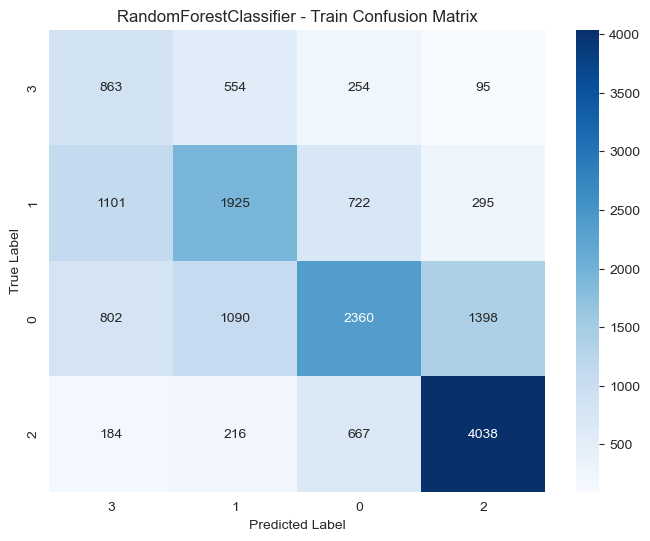

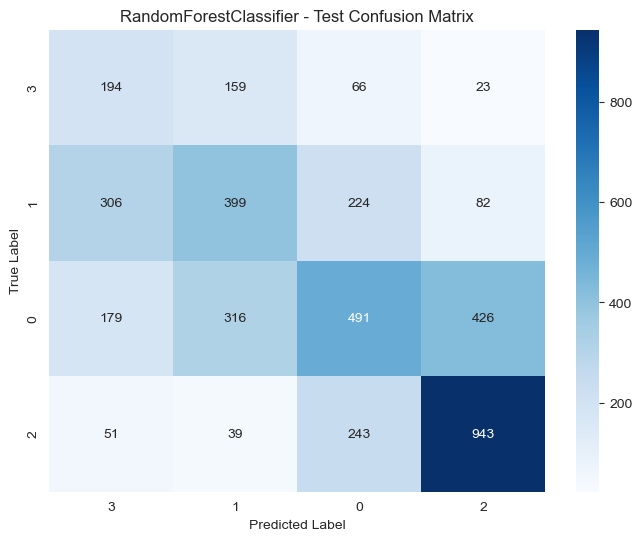

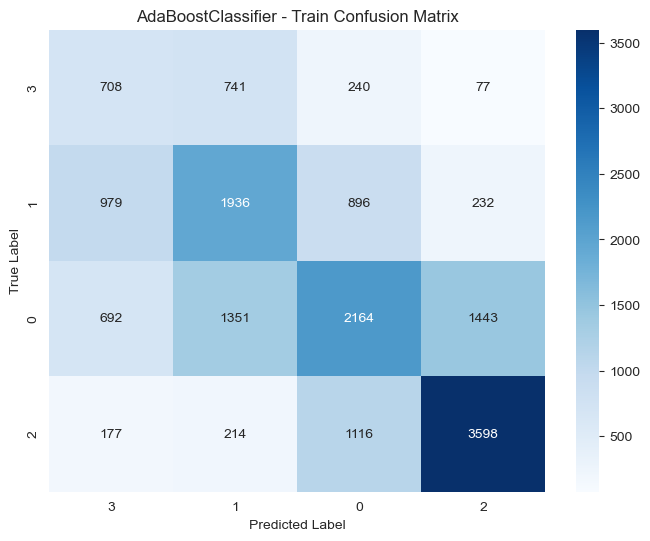

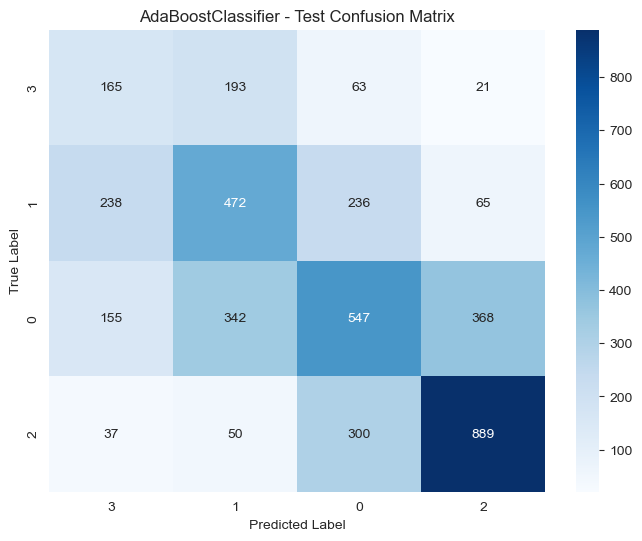

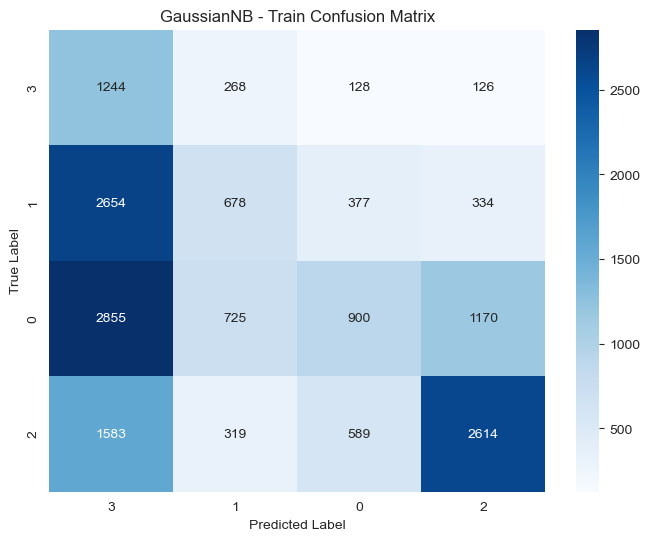

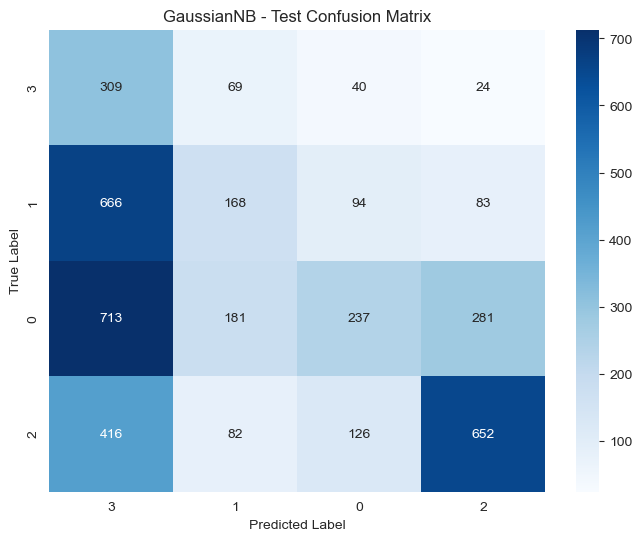

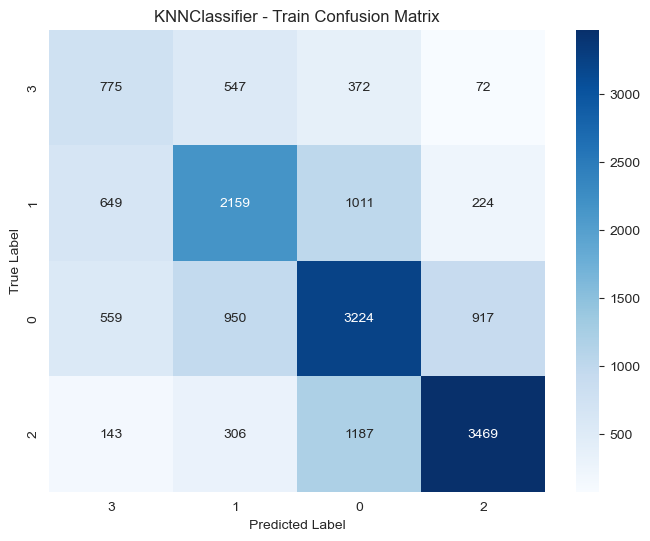

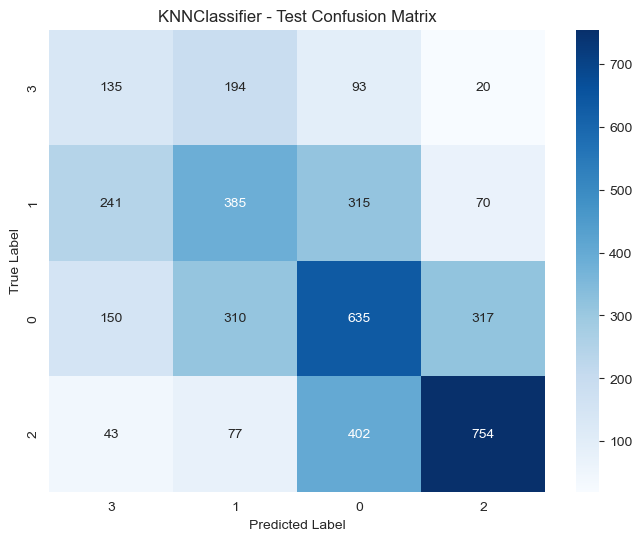

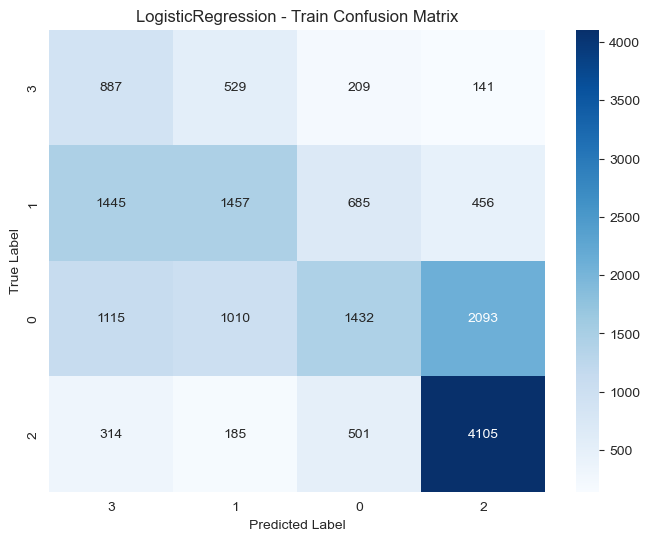

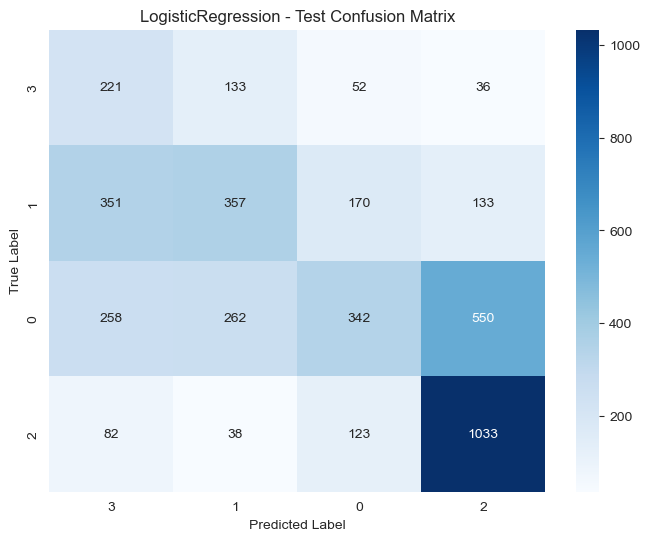

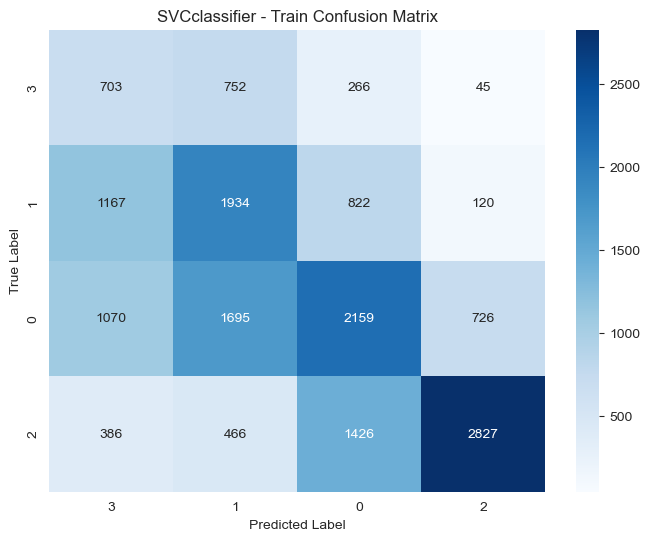

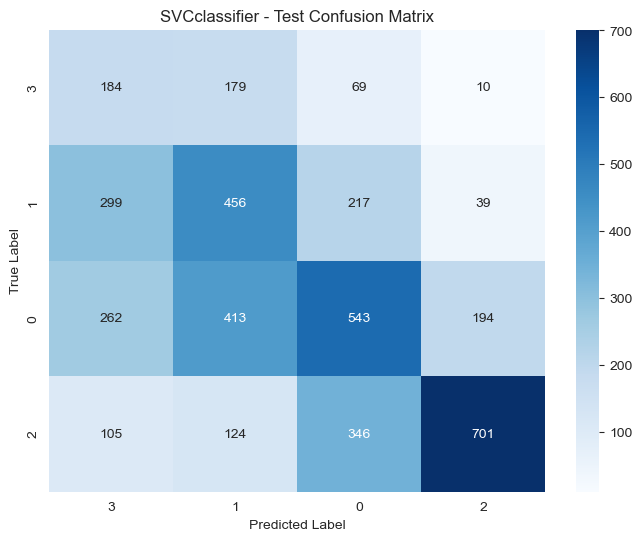

In [51]:

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

desired_order = [3, 1, 0, 2]

def reorder_confusion_matrix(cm, order):
    cm_new = cm[order, :]
    cm_new = cm_new[:, order]
    return cm_new

for name, classifier in classifiers.items():
    y_train_pred, y_test_pred = get_classifier_predictions(classifier, X_train_cla, X_test_cla)
    
    # Confusion matrix train set
    cm_train = confusion_matrix(y_train_cla, y_train_pred)
    cm_train_reordered = reorder_confusion_matrix(cm_train, desired_order)
    plot_confusion_matrix(cm_train_reordered, classes=[classifier.classes_[i] for i in desired_order], title=f'{name} - Train Confusion Matrix')

    # Confusion matrix test set
    cm_test = confusion_matrix(y_test_cla, y_test_pred)
    cm_test_reordered = reorder_confusion_matrix(cm_test, desired_order)
    plot_confusion_matrix(cm_test_reordered, classes=[classifier.classes_[i] for i in desired_order], title=f'{name} - Test Confusion Matrix')



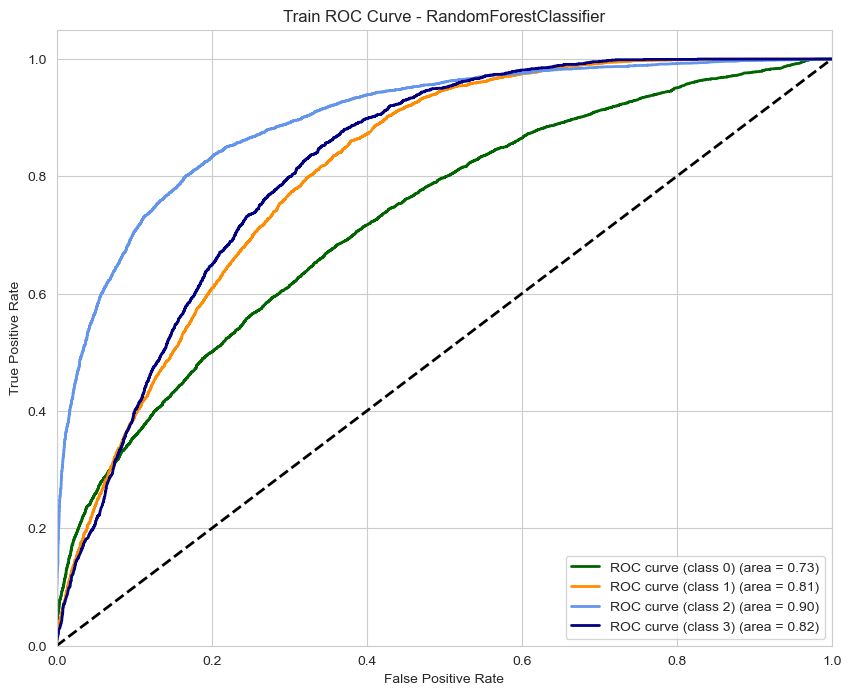

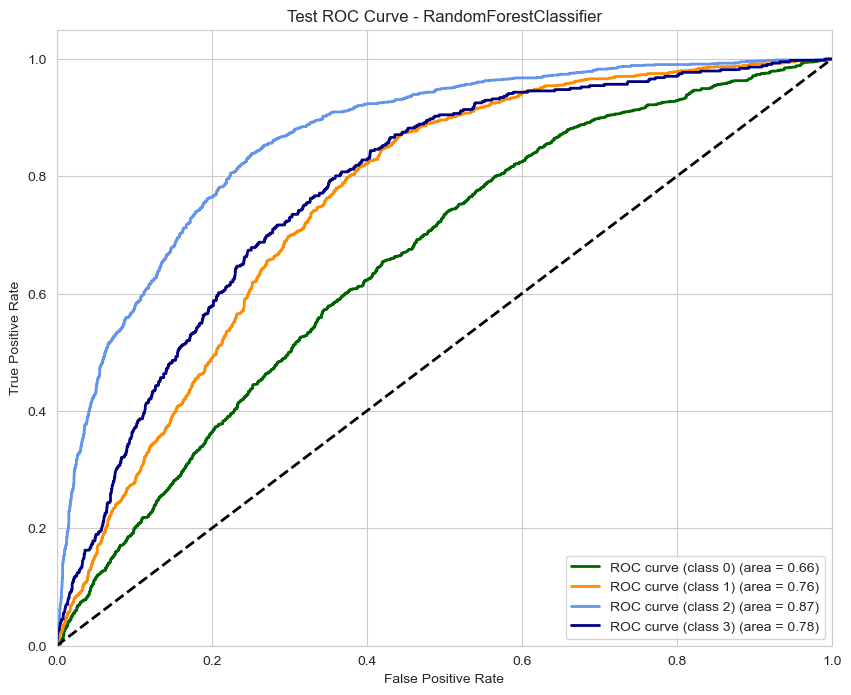

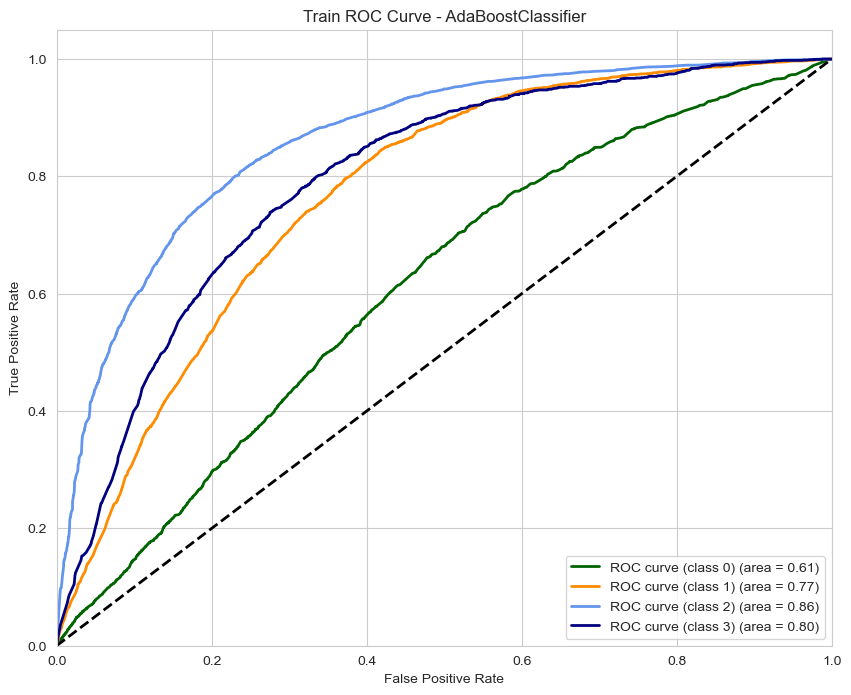

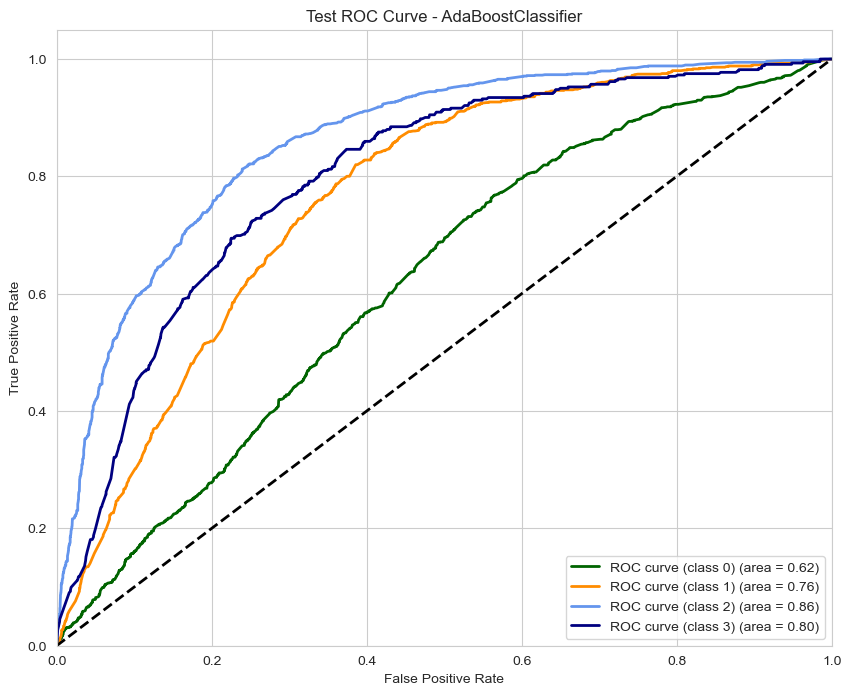

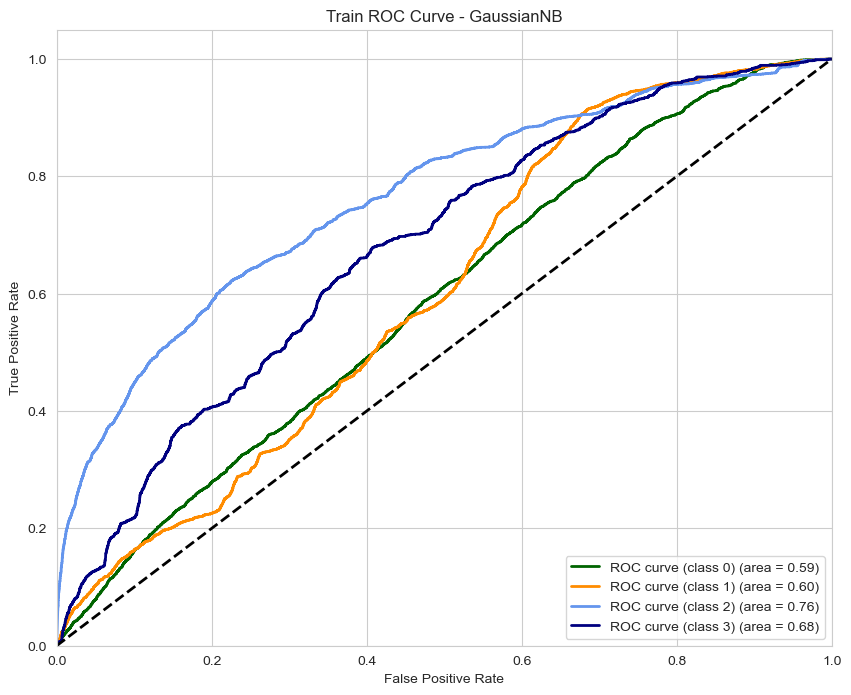

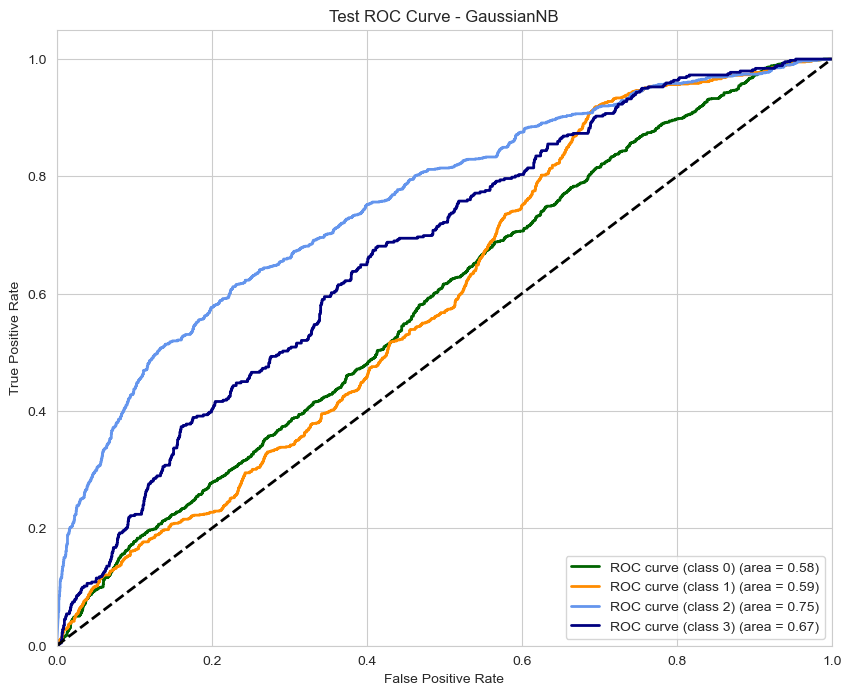

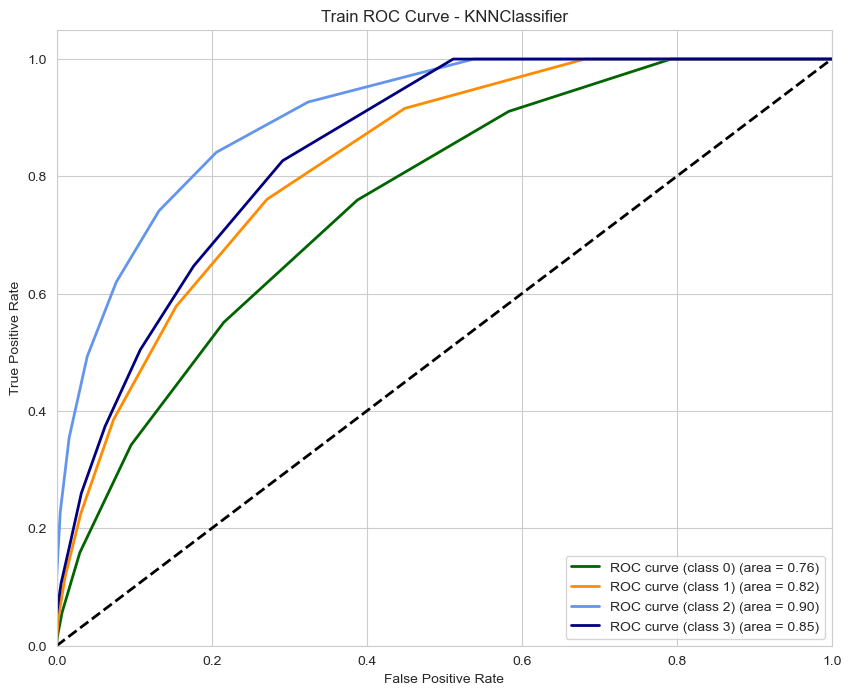

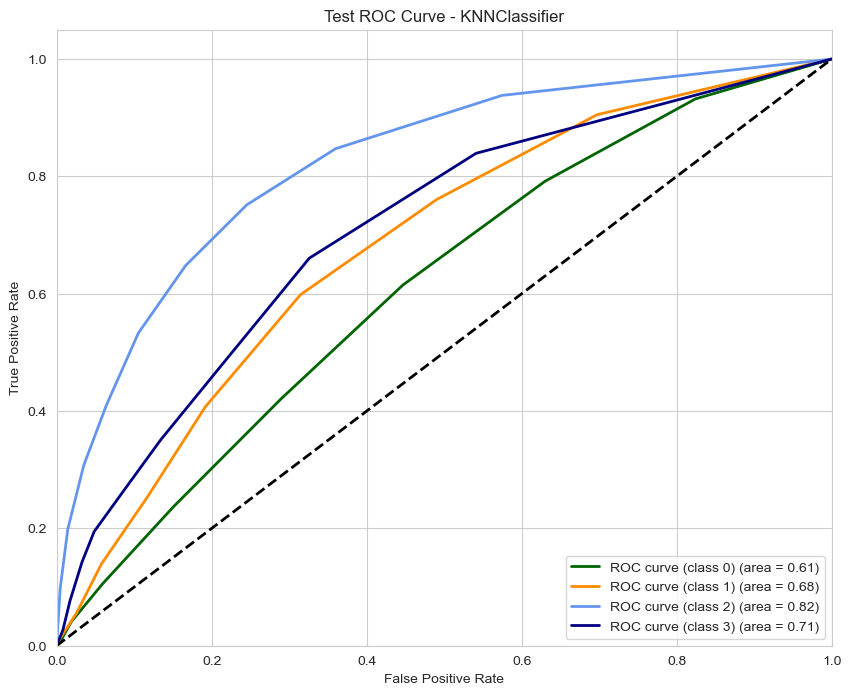

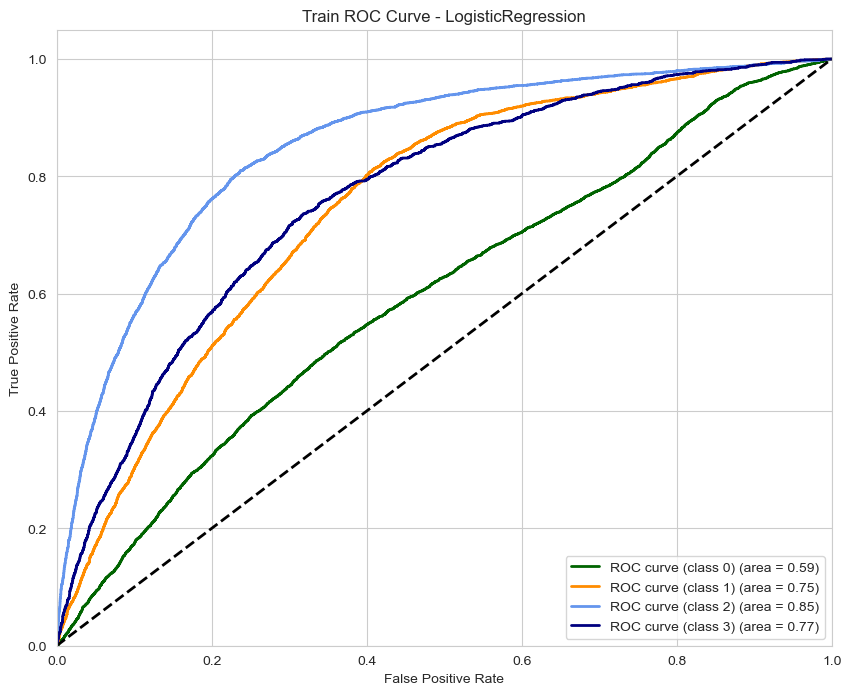

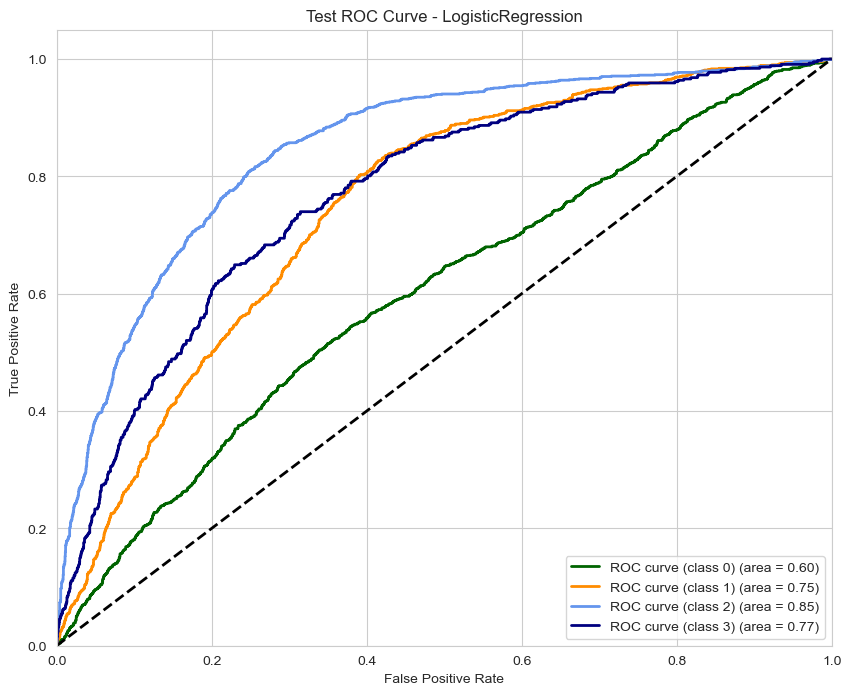

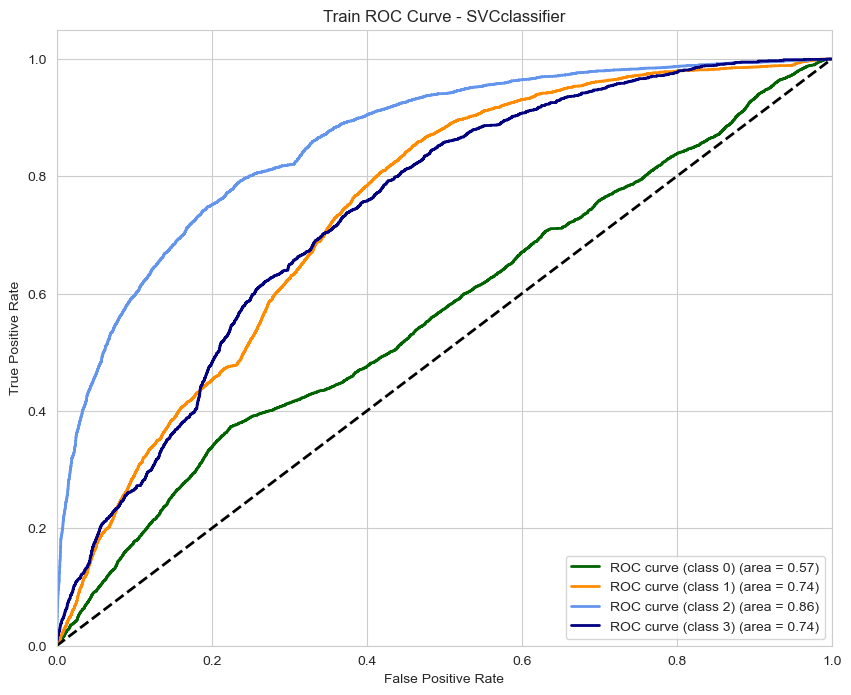

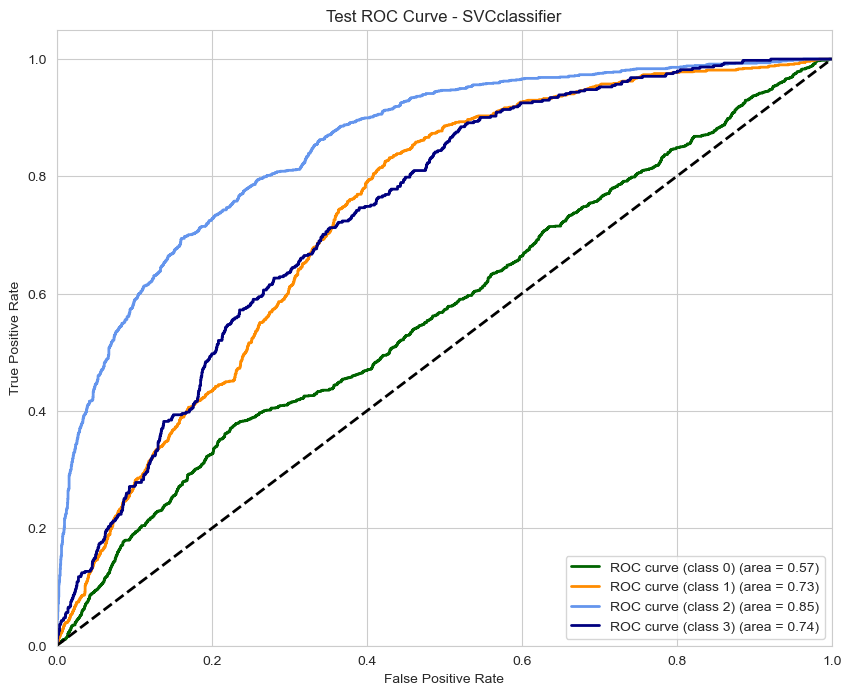

In [52]:

def get_classifier_probabilities(classifier, X_train, X_test):
    if hasattr(classifier, "predict_proba"):
        y_train_prob = classifier.predict_proba(X_train)
        y_test_prob = classifier.predict_proba(X_test)
    elif hasattr(classifier, "decision_function"):
        y_train_prob = classifier.decision_function(X_train)
        y_test_prob = classifier.decision_function(X_test)
    else:
        raise AttributeError(f"{classifier.__class__.__name__} does not have predict_proba or decision_function method.")
    return y_train_prob, y_test_prob

# multi-class ROC curve
def plot_multiclass_roc_curve(y_true, y_prob, classes, title='ROC Curve'):
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['darkgreen', 'darkorange', 'cornflowerblue', 'navy', 'darkgreen', 'darkred'])
    
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label=f'ROC curve (class {classes[i]}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()


for name, classifier in classifiers.items():
    y_train_prob, y_test_prob = get_classifier_probabilities(classifier, X_train_cla, X_test_cla)
    
    # Curve ROC train set   
    plot_multiclass_roc_curve(y_train_cla, y_train_prob, classes=classifier.classes_, title=f'Train ROC Curve - {name}')
    
    # Curve ROC test set
    plot_multiclass_roc_curve(y_test_cla, y_test_prob, classes=classifier.classes_, title=f'Test ROC Curve - {name}')


In [53]:

def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    results = {}
    for name, classifier in classifiers.items():

        y_train_pred = classifier.predict(X_train)
        y_test_pred = classifier.predict(X_test)

        train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
        test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        train_report = classification_report(y_train, y_train_pred)
        test_report = classification_report(y_test, y_test_pred)
        
        results[name] = {
            'train_balanced_accuracy': train_bal_acc,
            'test_balanced_accuracy': test_bal_acc,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_classification_report': train_report,
            'test_classification_report': test_report
        }
        
    return results

results = evaluate_classifiers(classifiers, X_train_cla, y_train_cla, X_test_cla, y_test_cla)

for name, metrics in results.items():
    print(f"Classifier: {name}")
    print(f"Train Balanced Accuracy: {metrics['train_balanced_accuracy']:.4f}")
    print(f"Test Balanced Accuracy: {metrics['test_balanced_accuracy']:.4f}")
    print(f"Train Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print("\nTrain Classification Report:\n", metrics['train_classification_report'])
    print("\nTest Classification Report:\n", metrics['test_classification_report'])
    print("\n" + "="*60 + "\n")


Classifier: RandomForestClassifier
Train Balanced Accuracy: 0.5434
Test Balanced Accuracy: 0.4801
Train Accuracy: 0.5546
Test Accuracy: 0.4895

Train Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.42      0.49      5650
           1       0.51      0.48      0.49      4043
           2       0.69      0.79      0.74      5105
           3       0.29      0.49      0.37      1766

    accuracy                           0.55     16564
   macro avg       0.52      0.54      0.52     16564
weighted avg       0.57      0.55      0.55     16564


Test Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.35      0.40      1412
           1       0.44      0.39      0.41      1011
           2       0.64      0.74      0.69      1276
           3       0.27      0.44      0.33       442

    accuracy                           0.49      4141
   macro avg       0.46      0.48  